# Continuos Bag of Words 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import requests
import os
import tarfile
import io
from nltk.corpus import stopwords
import re
import time

In [2]:
"""
    The following seek and save reviews 10,000 from movies.
"""
def load_movies_data():
    # Define paths
    save_folder_name = 'movies_data'
    pos_file = os.path.join(save_folder_name, 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polarity.neg')
    
    if os.path.exists(pos_file) and os.path.exists(neg_file):
        ## Get the data from path
        pos_data = []
        with open(pos_file, 'r') as pos_file_handler:
            for row in pos_file_handler:
                pos_data.append(row)
        neg_data = []
        with open(neg_file, 'r') as neg_file_handler:
            for row in neg_file_handler:
                neg_data.append(row)
    else:
        # Download data from url
        url = "https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz"
        req = requests.get(url)
        # Performe Request
        if req.ok:
            stream_data = io.BytesIO(req.content)
            tmp = io.BytesIO() 
            while True:
                s = stream_data.read(16384)
                if not s:
                    break
                tmp.write(s)
            stream_data.close()
            tmp.seek(0)
        else:
            raise ConnectionError(f"Something went wrong. Code: {req.code}")
        # Extract tar File
        tar_file = tarfile.open(fileobj= tmp, mode= "r:gz")
        pos = tar_file.extractfile('rt-polaritydata/rt-polarity.pos')
        neg = tar_file.extractfile('rt-polaritydata/rt-polarity.neg')
        # Get positive reviews
        pos_data = []
        for line in pos:
            pos_data.append(line.decode("ISO-8859-1").encode('ascii', errors= 'ignore').decode())
        # Get negative reviews
        neg_data = []
        for line in neg:
            neg_data.append(line.decode('ISO-8859-1').encode('ascii', errors= 'ignore').decode())
        tar_file.close()
        # Save data
        os.makedirs(save_folder_name, exist_ok= True)
        with open(pos_file, 'w') as pos_file_handler:
            pos_file_handler.write(''.join(pos_data))
        with open(neg_file, 'w') as neg_file_handler:
            neg_file_handler.write(''.join(neg_data))
    texts = pos_data + neg_data
    target = [1]*len(pos_data) + [0]*len(neg_data)
    return (texts, target)

In [3]:
"""
    Function to Performe Text Cleaning
"""
def normalize_text(texts, stop):
    texts = [x.lower() for x in texts] # To lower case
    texts = [re.findall(pattern= "[a-z]+", string= x) for x in texts] # Remove Numbers and Punctuation marks
    texts = [' '.join([x for x in row if x not in stop]) for row in texts ]
    return texts

In [4]:
"""
    Function to Build the Dictionary of Words
"""
def build_dictionary(sentences, vocabulary_size):
    words = []
    for sentence in sentences:
        words.extend(sentence.split())
    count= [['RARE', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    word_dict = {}
    for word, word_count in count:
        word_dict[word] = len(word_dict)
    return word_dict

In [5]:
"""
    Function to Encode the Text into One-hot structure.
"""

def text_to_numbers(sentences, word_dict):
    data = []
    for sentence in sentences:
        sentence_data = []
        for word in sentence.split():
            if word in word_dict:
                word_idx = word_dict[word]
            else:
                word_idx = 0
            sentence_data.append(word_idx)
        data.append(sentence_data)
    return data

In [6]:
"""
    Function to generate the batch for skip-gram / cbow
"""
def generate_batch_data(sentences, batch_size, window_size, method= 'skip_gram'):
    batch_data = []
    label_data = []
    # While until achieve the batch size 
    while len(batch_data) < batch_size:
        # Select a random sentence
        rand_idx = np.random.choice(len(sentences))
        rand_sentences = sentences[rand_idx]
        # Select words that are inside window, starting from 0 to window_size + 1,
        # which means at the beggining sequences won't have 2 * window_sixe + 1.
        window_seq = [rand_sentences[max(ix-window_size, 0):ix+window_size+1]
                  for ix, x in enumerate(rand_sentences)]
        label_idx = [ix if ix < window_size else window_size for ix, x in enumerate(window_seq)]
        if method == 'skip_gram':
            # Split the middle word with the rest of the context
            batch_and_labels = [(x[y], x[:y]+x[y+1:]) for x,y in zip(window_seq, label_idx)]
            tuple_data = [(x,y_) for x, y in batch_and_labels for y_ in y]
            batch, labels = [list(x) for x in zip(*tuple_data)]
        elif method == 'cbow':
            batch_and_labels = [(x[:y]+x[y+1:], x[y]) for x,y in zip(window_seq, label_idx)]
            batch_and_labels = [(x, y) for x,y in batch_and_labels if len(x) == 2*window_size]
            if not len(batch_and_labels):
                continue
            batch, labels = [list(x) for x in zip(*batch_and_labels)]
        else:
            raise ValueError(f'Invalid Method {method}.')
        
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array(label_data))
    return (batch_data, label_data)

### Define Hyperparameters

In [22]:
# Define Hyperparameters
batch_size= 128
embedding_size= 2
vocabulary_size= 2000
generations= 5000
print_loss_every= 1000
num_sampled= int(batch_size/2)
window_size= 3
stop_words= set(stopwords.words('english'))
print_valid_every= 2000
valid_words= ['love','hate','happy','sad','man','woman']

#### Data Cleaning

In [23]:
# Load the data
texts, target= load_movies_data()
# Data Cleaning
texts= normalize_text(texts, stop_words)
texts= [x for x in texts if len(x.split()) > 2]

# Build the Dictionary
word_dict= build_dictionary(texts, vocabulary_size)
# Build Reverse Dictionary
word_dict_rev= dict(zip(word_dict.values(), word_dict.keys()))

# Encode text to number
text_data= text_to_numbers(texts, word_dict)
# Encode the validation words into numbers
valid_examples= [word_dict[x] for x in valid_words]

#### Training the CBOW

In [24]:
# Weights / Bias
embeddings = tf.Variable(tf.random.uniform(shape= [embedding_size, vocabulary_size], 
                                           minval= 0, maxval= 1, dtype= tf.float32))
b0 = tf.Variable(tf.zeros(shape= [embedding_size, 1], dtype= tf.float32))
W1 = tf.Variable(tf.random.uniform(shape= [vocabulary_size, embedding_size], 
                                   minval= 0, maxval= 1, dtype= tf.float32))
b1 = tf.Variable(tf.zeros(shape= [vocabulary_size, 1], dtype= tf.float32))

# Identity Matrix
identity = tf.linalg.diag(tf.ones(shape= [vocabulary_size], dtype= tf.float32))
# Function to one_hot samples
@tf.function
def one_hot(samples, transpose= False):
    encoded = tf.nn.embedding_lookup(identity, samples) 
    if len(encoded.shape) == 3:
        encoded= tf.reduce_max(encoded, axis= 1)
    if transpose:
        return tf.transpose(encoded)
    return encoded

# Neural Network
@tf.function
def model(X):
    A0 = tf.nn.relu(tf.matmul(embeddings, X) + b0)
    A1 = tf.nn.softmax(tf.matmul(W1, A0) + b1, axis= 0)
    return A1

# Loss Function
@tf.function
def loss_function(y_true, y_pred):
    y_pred_t = tf.transpose(y_pred)
    return tf.reduce_sum(tf.losses.categorical_crossentropy(y_true, y_pred_t)) / len(y_pred)

# Compute the Similarity Between validation words and all the vocabulary words
@tf.function
def compute_similarity(embeddings, val_idx, topk= 10):
    # Normalize Embeddings
    embeddings_t = tf.transpose(embeddings)
    norm = tf.math.sqrt(tf.reduce_sum(tf.square(embeddings_t), 1, keepdims= True))
    norm_embeddings = embeddings_t / norm # n_words, embedding_size
    # Get Validation words
    validation_words= tf.nn.embedding_lookup(norm_embeddings, val_idx) # n_samples, 200
    # Dot Product
    cos_similarity = tf.matmul(validation_words, norm_embeddings, transpose_b= True)
    # Get top K words
    values_K, idx_K = tf.nn.top_k(-cos_similarity, k= topk, )
    return idx_K

# Optimizer
eta = 0.1
my_opt = tf.optimizers.legacy.Adam(learning_rate= eta)

# Main Loop
loss_vect = []
start_time= time.time()
for ite in range(1, generations+1):
    X_idx, y_idx = generate_batch_data(text_data, batch_size, window_size, method= 'cbow')
    X_input= tf.constant(one_hot(X_idx, transpose= True), dtype= tf.float32)
    y_input= tf.constant(one_hot(y_idx), dtype= tf.float32)

    with tf.GradientTape() as g:
        g.watch(embeddings)
        g.watch(b0)
        g.watch(W1)
        g.watch(b1)

        output= model(X_input)
        loss= loss_function(y_input, output)
    gradients= g.gradient(loss, [embeddings, b0, W1, b1])
    my_opt.apply_gradients(zip(gradients, [embeddings, b0, W1, b1]))

    if ite % print_loss_every == 0:
        print(f"Iterations: {ite} -- Loss: {loss.numpy()}")
    if ite % print_valid_every == 0:
        similarity_idx = compute_similarity(embeddings, valid_examples, topk= 10)
        for idx, val in enumerate(valid_words):
            print(f'Word: {val} Similarity: ', end= '')
            for k in similarity_idx[idx].numpy():
                print(f'{word_dict_rev[k]}', end= ' - ')
            print()
    loss_vect.append(loss.numpy())

end_time= time.time()
print('Time: ')
print(end_time - start_time)

Iterations: 1000 -- Loss: 0.3458626866340637
Iterations: 2000 -- Loss: 0.3274305462837219
Word: love Similarity: tsai - ugly - job - digital - acts - visual - put - pleasure - called - points - 
Word: hate Similarity: day - opera - face - good - silly - girl - damned - could - going - mark - 
Word: happy Similarity: somewhere - boy - intensity - flashy - probably - shot - loss - quirky - serious - humanity - 
Word: sad Similarity: opera - good - day - damned - going - mark - crafted - imagination - try - ups - 
Word: man Similarity: minute - um - effectively - kevin - changing - speaking - grief - absorbing - couple - running - 
Word: woman Similarity: adolescent - mayhem - true - pointless - soderbergh - offering - fly - turns - proceedings - favor - 
Iterations: 3000 -- Loss: 0.35380062460899353
Iterations: 4000 -- Loss: 0.3250289559364319
Word: love Similarity: hoffman - deal - middle - poem - strangely - godard - band - puts - families - double - 
Word: hate Similarity: odd - versi

In [25]:
word_vects = tf.transpose(embeddings).numpy() # (vocabulary_size, embedding_size)

In [43]:
# king - man + women
queen_vect = word_vects[word_dict['king']] + word_vects[word_dict['man']] - word_vects[word_dict['women']] - 0.8 # (600,)
queen = queen_vect.reshape(1,1,queen_vect.shape[0]) # (1,1,embeddings)

# L2 Norm
l2_norm = np.power(queen-word_vects, 2) # (1, vocabulary_size, embedding_size)
sum_l2_norm = np.sum(l2_norm, axis= 2) # (1, vocabulary_size)

# Get Nearest Vector
idx = np.argmin(sum_l2_norm)
word_dict_rev[idx]

'hip'

#### Save the Embeddings

In [12]:
import pickle

In [13]:
# Save the Embeddings
with open(os.path.join('Resources', 'cbow-200.pickle'), 'wb') as f:
    pickle.dump(word_vects, f, pickle.HIGHEST_PROTOCOL)

### Visualize Embeddings

In [44]:
sentiment_words = ['hip','water', 'love', 'hate','happy','sad', 'men', 'boy', 'women', 'queen', 'king', 'gentle', 'man', 'goofy']
sentiment_idx = [word_dict[x] for x in sentiment_words]
sentiment_embeddings = word_vects[sentiment_idx]
sentiment_embeddings.shape

(14, 2)

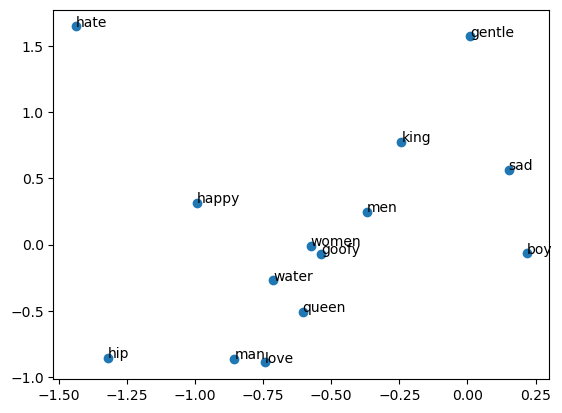

In [45]:
plt.scatter(sentiment_embeddings[:, 0], sentiment_embeddings[:, 1])

for i, idx in enumerate(sentiment_idx):
    plt.text(x= sentiment_embeddings[i,0], y= sentiment_embeddings[i,1], s= word_dict_rev[idx])
plt.show()